In [13]:
# !pip install pandas
# !pip install tensorflow
# !pip install keras
# !pip install sklearn

import pandas as pd
from dataset import get_dataframe

In [14]:
df = get_dataframe('./dataset')

In [15]:
df.head()
list(df)
df.shape

(8475, 28)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [17]:
# Cleaning dataframe to avoid using NA rating
df.dropna()
dataCleaned = df[df.rating != "NA"]

In [18]:
dataCleaned['label'] = dataCleaned['rating'].factorize()[0]
dataCleaned

/home/mahesh/Documents/GITHUB/GITHUB/MovieMetaPredict/models/classification/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,link,id,name,year,rating,genre,runtime,imdb_rate,description,Votes,...,meta.Runtime:,meta.Color:,meta.Aspect Ratio:,meta.storyline,meta.Budget:,meta.Opening Weekend USA:,meta.Gross USA:,meta.Sound Mix:,meta.rating,label
0,http://www.imdb.com/title/tt10037014/,tt10037014,Fear of Rain,2021,PG-13,"Drama, Horror, Thriller",109,5.9,A girl living with schizophrenia struggles wit...,1937.0,...,109.0,[Color],1.85 : 1,A girl living with schizophrenia struggles wit...,NaN,NaN,NaN,NaN,NaN,0
0,http://www.imdb.com/title/tt0468569/,tt0468569,The Dark Knight,2008,PG,"Action, Crime, Drama",152,9.0,When the menace known as the Joker wreaks havo...,2322446.0,...,152.0,[Color],2.39 : 1,Set within a year after the events of Batman B...,1.85e+08,1.584115e+10,534858444.0,"[Dolby Digital, SDDS, DTS, IMAX 6-Track]",PG,1
1,http://www.imdb.com/title/tt0371746/,tt0371746,Iron Man,2008,PG,"Action, Adventure, Sci-Fi",126,7.9,"After being held captive in an Afghan cave, bi...",947330.0,...,126.0,[Color],2.39 : 1,"Tony Stark. Genius, billionaire, playboy, phil...",1.4e+08,9.861867e+08,319034126.0,"[SDDS, Dolby Digital, DTS, Dolby Atmos]",PG,1
2,http://www.imdb.com/title/tt1099212/,tt1099212,Twilight,I 2008,PG,"Drama, Fantasy, Romance",122,5.2,When Bella Swan moves to a small town in the P...,429446.0,...,122.0,"[Color, Black and White]",2.35 : 1,Bella Swan has always been a little bit differ...,3.7e+07,6.963774e+09,193962473.0,"[DTS, Dolby Digital, SDDS, Dolby Atmos]",PG,1
3,http://www.imdb.com/title/tt0942385/,tt0942385,Tropic Thunder,2008,18A,"Action, Comedy, War",107,7.0,"Through a series of freak occurrences, a group...",380181.0,...,107.0,[Color],2.35 : 1,Action movie star Tugg Speedman is on the down...,9.2e+07,2.581280e+09,110515313.0,"[SDDS, Dolby Digital, DTS]",18A,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,http://www.imdb.com/title/tt0091668/,tt0091668,Off Beat,1986,PG,"Comedy, Crime, Romance",92,5.1,Joe Gower's job is skating through library she...,860.0,...,92.0,[Color],1.85 : 1,Joe Gower's job is skating through library she...,NaN,2.011192e+08,4842778.0,[Dolby],PG,1
191,http://www.imdb.com/title/tt0090779/,tt0090779,Bullies,1986,18+,"Action, Drama, Thriller",96,5.3,The Morris family moves from the city in an at...,445.0,...,96.0,[Color],NaN,When the peaceful Morris family move to a smal...,"CAD1,800,000",1.532605e+07,2995527.0,[Mono],18+,11
195,http://www.imdb.com/title/tt0090799/,tt0090799,Care Bears Movie II: A New Generation,1986,F,"Animation, Adventure, Comedy",76,5.5,The Care Bears try to help a young girl at sum...,2145.0,...,76.0,[Color],1.85 : 1,In this second installment to the original Car...,NaN,NaN,8540346.0,"[Mono, Dolby Stereo]",F,15
202,http://www.imdb.com/title/tt0091370/,tt0091370,The Ladies Club,1986,R,"Crime, Drama, Thriller",85,5.6,A raped policewoman forms a vigilante group of...,217.0,...,85.0,[Color],1.85 : 1,Joan Taylor is a Los Angeles policewoman whom ...,NaN,NaN,239073.0,[Mono],R,6


In [35]:
from io import StringIO
rate_to_id_df = dataCleaned[['rating', 'label']].drop_duplicates().sort_values('label')
rate_to_id = dict(rate_to_id_df.values)
id_to_rate = dict(rate_to_id_df[['label', 'rating']].values)

In [36]:
dataCleaned.head()

,link,id,name,year,rating,genre,runtime,imdb_rate,description,Votes,...,meta.Runtime:,meta.Color:,meta.Aspect Ratio:,meta.storyline,meta.Budget:,meta.Opening Weekend USA:,meta.Gross USA:,meta.Sound Mix:,meta.rating,label
0,http://www.imdb.com/title/tt10037014/,tt10037014,Fear of Rain,2021,PG-13,"Drama, Horror, Thriller",109,5.9,A girl living with schizophrenia struggles wit...,1937.0,...,109.0,[Color],1.85 : 1,A girl living with schizophrenia struggles wit...,NaN,NaN,NaN,NaN,NaN,0
0,http://www.imdb.com/title/tt0468569/,tt0468569,The Dark Knight,2008,PG,"Action, Crime, Drama",152,9.0,When the menace known as the Joker wreaks havo...,2322446.0,...,152.0,[Color],2.39 : 1,Set within a year after the events of Batman B...,1.85e+08,1.584115e+10,534858444.0,"[Dolby Digital, SDDS, DTS, IMAX 6-Track]",PG,1
1,http://www.imdb.com/title/tt0371746/,tt0371746,Iron Man,2008,PG,"Action, Adventure, Sci-Fi",126,7.9,"After being held captive in an Afghan cave, bi...",947330.0,...,126.0,[Color],2.39 : 1,"Tony Stark. Genius, billionaire, playboy, phil...",1.4e+08,9.861867e+08,319034126.0,"[SDDS, Dolby Digital, DTS, Dolby Atmos]",PG,1
2,http://www.imdb.com/title/tt1099212/,tt1099212,Twilight,I 2008,PG,"Drama, Fantasy, Romance",122,5.2,When Bella Swan moves to a small town in the P...,429446.0,...,122.0,"[Color, Black and White]",2.35 : 1,Bella Swan has always been a little bit differ...,3.7e+07,6.963774e+09,193962473.0,"[DTS, Dolby Digital, SDDS, Dolby Atmos]",PG,1
3,http://www.imdb.com/title/tt0942385/,tt0942385,Tropic Thunder,2008,18A,"Action, Comedy, War",107,7.0,"Through a series of freak occurrences, a group...",380181.0,...,107.0,[Color],2.35 : 1,Action movie star Tugg Speedman is on the down...,9.2e+07,2.581280e+09,110515313.0,"[SDDS, Dolby Digital, DTS]",18A,2


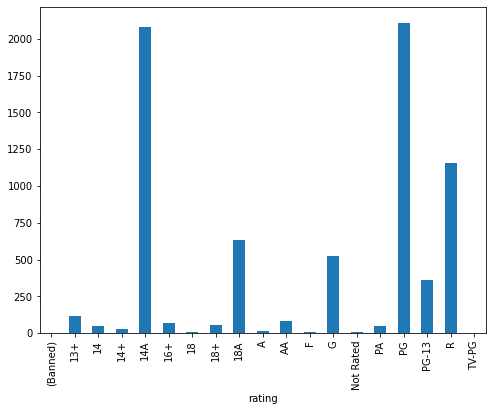

In [30]:
# VIEW THE DISTRIBUTION OF LABELS
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dataCleaned.groupby('rating')['meta.storyline'].count().plot.bar(ylim=0)
plt.show()

In [37]:
# Vectorize Text
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(dataCleaned['meta.storyline']).toarray()
labels = dataCleaned.label
features.shape

(7357, 13260)

In [39]:
# CALCULATE CHI2 :: FIND UNIGRAMS
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for rating, label_index in sorted(rate_to_id.items()):
  features_chi2 = chi2(features, labels == label_index)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(rating))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# '(Banned)':
  . Most correlated unigrams:
       . flirtatious
       . jeffrey
  . Most correlated bigrams:
       . tragic consequences
       . young italian
# '13+':
  . Most correlated unigrams:
       . brosnan
       . 007
  . Most correlated bigrams:
       . james bond
       . pierce brosnan
# '14':
  . Most correlated unigrams:
       . dominique
       . orgasm
  . Most correlated bigrams:
       . minor league
       . new town
# '14+':
  . Most correlated unigrams:
       . bryce
       . owning
  . Most correlated bigrams:
       . rescue team
       . job interview
# '14A':
  . Most correlated unigrams:
       . machines
       . terrorist
  . Most correlated bigrams:
       . bradley cooper
       . terrorist attack
# '16+':
  . Most correlated unigrams:
       . dante
       . blade
  . Most correlated bigrams:
       . trials tribulations
       . seek revenge
# '18':
  . Most correlated unigrams:
       . boost
       . ratings
  . Most correlated bigrams:
       

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(dataCleaned['meta.storyline'], dataCleaned['rating'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [43]:
## TRAINING
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/mahesh/Documents/GITHUB/GITHUB/MovieMetaPredict/models/classification/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/mahesh/Documents/GITHUB/GITHUB/MovieMetaPredict/models/classification/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/mahesh/Documents/GITHUB/GITHUB/MovieMetaPredict/models/classification/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/mahesh/Documents/GITHUB/GITHUB/MovieMetaPredict/models/classification/venv/lib/python3.6/site-packages/sklearn/model_selecti

In [71]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, dataCleaned.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

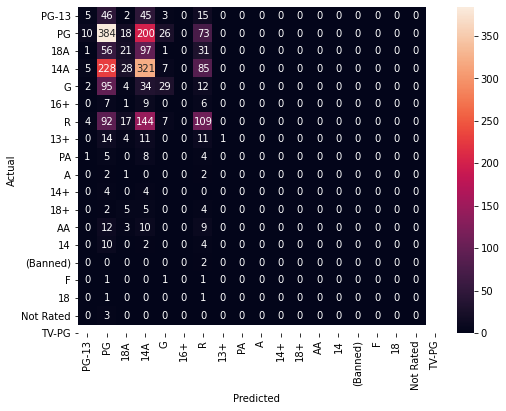

In [72]:
# CONFUSION MATRIX
!pip install seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=rate_to_id_df.rating.values, yticklabels=rate_to_id_df.rating.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [78]:
model.fit(features, labels)
print(labels.unique())
print(dataCleaned['rating'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
['PG-13' 'PG' '18A' '14A' 'G' '16+' 'R' '13+' 'PA' 'A' '14+' '18+' 'AA'
 '14' '(Banned)' 'F' '18' 'Not Rated' 'TV-PG']


In [81]:
# from sklearn.feature_selection import chi2

# N = 2
# for rating, label_id in sorted(rate_to_id.items()):
#   indices = np.argsort(model.coef_[label_id])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
#   bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
#   print("# '{}':".format(rating))
#   print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
#   print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [87]:
dataLabels = dataCleaned['rating'].unique()
dataLabels = np.delete(dataLabels, 17)

In [88]:
# METRICS
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=dataLabels))

              precision    recall  f1-score   support

       PG-13       0.18      0.04      0.07       116
          PG       0.40      0.54      0.46       711
         18A       0.20      0.10      0.14       207
         14A       0.36      0.48      0.41       674
           G       0.39      0.16      0.23       176
         16+       0.00      0.00      0.00        23
           R       0.30      0.29      0.29       373
         13+       1.00      0.02      0.05        41
          PA       0.00      0.00      0.00        18
           A       0.00      0.00      0.00         5
         14+       0.00      0.00      0.00         8
         18+       0.00      0.00      0.00        16
          AA       0.00      0.00      0.00        34
          14       0.00      0.00      0.00        16
    (Banned)       0.00      0.00      0.00         2
           F       0.00      0.00      0.00         3
          18       0.00      0.00      0.00         2
       TV-PG       0.00    

/home/mahesh/Documents/GITHUB/GITHUB/MovieMetaPredict/models/classification/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahesh/Documents/GITHUB/GITHUB/MovieMetaPredict/models/classification/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahesh/Documents/GITHUB/GITHUB/MovieMetaPredict/models/classification/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la